In [1]:
#Import Required Packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.spatial.distance import cdist as cdst

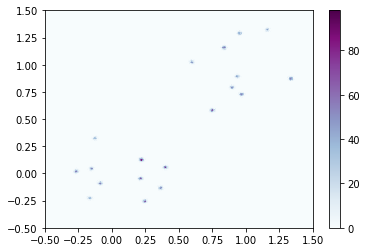

In [2]:
#Import Data Set
Raw_df = pd.read_csv('Data.csv')
#print(Raw_df)
#Raw_df = Raw_df[Raw_df['power_level']==5]
#sns.jointplot(x= Raw_df['xcoordinate'], y= Raw_df['ycoordinate'], kind='kde')
#plt.show()
#plt.close()
#All power_bar levels are aproxmantly equally distributed within the 19 concetrated scooter zones
#Checked with Seaborne jointplot
plt.hist2d(x= Raw_df['xcoordinate'], y= Raw_df['ycoordinate'], bins = np.linspace(-0.5,1.5,400), cmap=plt.cm.BuPu)
plt.colorbar()
plt.show()
plt.close()

#The highest concentration scooter zone is ~(0.23, 0.15) with 18 other nodes of hih concentration.
#These nodes are close to 2D-Gaussian distributions so they can be well aproxmated by circles.
#All of the nodes are within the same 2 square mile area which is far from the bus station at (20.19,20.19)

In [ ]:
#Assumptions
##The bus travels at 50 miles per hour at all times, except when it is stopped at the station (20.19,20.19) where crews can relax while scooters inside the bus are charging.
##The bus can also hold 20 scooters at any one time
#Methodology
##We will try to minimize charging time
##So overall the bus will preference scooters with theese proirities, in this order:
###1. If the bus is empty it will preference the closest scooter, allowing for a variety of different charging time should lead to less waiting time between pickups
###2. If the bus is full it will attempt to find a scooter to travel to that will align with the charging time necessary to drop a fully charged scooter off.  This will also minimize down time.
###3. If no scooters fall outside the range for number 2 the bus will move back to the station and wait if a scooter has not finished charging by the time it arrives.
#Discussion
##While the measures taken is step 3 are not the most effective, as it would be more efficient to travel in the opposite direction as the next closest scooter to the inside of the charging radius, it does give the bus workers an occasional break and is computationaly simplier.
##The bigest loss portion is the fact that the bus waits until a scooter is charged to leave the station.  Ideally, the bus would take into account how long it would take to reach the next scooter and leave acording to that.
##It is also worthwile to consider that each node could be mapped using a random seclection of start points and considered via k-nearest neighbor methodologies for a possible increase in efficency but once the bus is filled the result likely would look very similar.
##The KNN mapping could also need to be redone for each 'round' of bus filling.  This would be computationally intensive though.
##All in all I took a simplier approach due to both the limitations of my hardware and the time I had to complete the project, but I would like to explore these options in the future.

In [ ]:
Raw_df = pd.read_csv('Data.csv')
Raw_df = Raw_df[Raw_df['power_level']!=5]
Raw_df['coords'] = Raw_df[['xcoordinate','ycoordinate']].values.tolist()
class Bus():
    def __init__(self, Total_Time = 0, dataframe = Raw_df, location = [20.19,20.19], contents = [], velocity = 50, capacity = 20):
        self.Total_Time = Total_Time
        self.dataframe = dataframe
        self.velocity = velocity
        self.location = location
        self.contents = contents
        self.capacity = capacity
    def cycle(self):
        self.dataframe['distance'] = self.dataframe['coords'].apply(lambda x: abs(cdst([x], [self.location], metric='euclidean')))
        print('scooters:  ' + str(np.size(self.contents)))
        if np.size(self.contents) != self.capacity and self.dataframe.shape[0] != 0:
            loc_dx = self.dataframe['distance'].astype('float64').idxmin()
            print('New index loc(fill):  ' + str(self.dataframe['coords'][loc_dx]))
            Time_Traveled = self.dataframe['distance'][loc_dx]/self.velocity
            self.Total_Time = self.Total_Time + Time_Traveled
            if np.size(self.contents) != 0: #If there is open space, fill it as soon as possible
                self.contents = [x + Time_Traveled for x in self.contents]
            self.location = self.dataframe['coords'][loc_dx]
            self.contents.append(self.dataframe['power_level'][loc_dx])
            self.dataframe = self.dataframe.drop([loc_dx], axis = 0)
        else: #find next target scooter
            Dist_to_next_charge = 5 - self.contents.index(max(self.contents))*50
            self.dataframe['opt_dist'] = self.dataframe['distance'].apply(lambda x: x - Dist_to_next_charge)
            loc_dx = self.dataframe.loc[self.dataframe['opt_dist'] > 0, 'opt_dist'].min()
            if type(loc_dx) == int: #If possible go dircetly to an uncharged scooter with a fully cahrged one
                Time_Traveled = self.dataframe['distance'][loc_dx]/self.velocity
                self.Total_Time = self.Total_Time + Time_Traveled
                self.location = self.dataframe['coords'][loc_dx]
                self.contents = [x + Time_Traveled for x in self.contents]
                self.contents.append(self.dataframe['power_level'][loc_dx])
                self.dataframe = self.dataframe.drop[loc_dx]
                print('New index loc(fill2):  ' + str(self.dataframe['coords'][loc_dx]))
            elif self.location != [20.19,20.19]: #Traveling to the station
                Dist_Station = abs(cdst([[20.19,20.19]], [self.location], metric='euclidean'))
                Time_Traveled = Dist_Station/self.velocity
                self.Total_Time = self.Total_Time + Time_Traveled
                self.contents = [x + Time_Traveled for x in self.contents]
                self.location = [20.19,20.19]
                print('New index loc(station):  ' + str(self.location))
            else: #Waiting at the station
                Time_Traveled = 0.1
                self.Total_Time = self.Total_Time + Time_Traveled
                self.contents = [x + Time_Traveled for x in self.contents]
                print('New index loc(wait):  ' + str(self.location))
        for x in self.contents: #Scooter drop off
            if x >= 5:
                self.contents.remove(x)
                
B = Bus()
while B.dataframe.shape[0] != 0:
    B.cycle()
    print('Scooters Remaining: ' + str(B.dataframe.shape[0]))
print('Total time to charge all scooters:' + str(B.Total_Time))

In [ ]:
#Total time to charge all scooters: 3685.039 Hours
#Perfect time (if all 20 chargers we always running and there was no travel time): 3203.45 Hours
#Total effiecncy: 86.93%

#While theniterative process was not particularly fast to run I belive it was an effective solution, even if a little quick and dirty in its construction.
#The existinig code also lay a good frame work for future improvement
#Unfortunatly the fill2, which was the most time efficent option, rarely triggers due to the constant velocity of the bus.  A future model could imporve upon this by altering the spped to be lower depending on the target (assuming the 50mph is an upper limit).

#I had a lot of fun figuring out this problem.  Regaurdless of the end result i would love feedback on my work, methodolgy, code or otherwise.
#The way that acidemic research, specifically and especially physics, is often condsidered "quick and dirty" so I've tried to mimic a different style of coding thatn I normally do
